# 02 - Data from the Web


In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need! You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this brief tutorial to understand quickly how to use it.

In [26]:
from bs4 import BeautifulSoup
import requests
import json
import string
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools
import unicodedata
from textblob.blob import TextBlob

# Methods

## Ratio calculation

In [27]:
def ratio(a, b):
    a = float(a)
    b = float(b)
    if b == 0:
        return a
    return ratio(b, a % b)

# Task 1 - Data from QS ranking

## Question 1

Multiple strategies have been testes in order to find the data used to construct the table of the QS Rankings. However, only one of them led to the expected result. We opened the Web Inspector on the website. Among the ressources used by the page, a text file named 'XHR/357051.txt'  was containing the expected ranking with the desired informations. 

In [28]:
URL_QS = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508497791260'
r = requests.get(URL_QS)
page_body = r.json()
qs_df = pd.DataFrame(page_body['data'])
qs_df = qs_df.drop(['core_id','logo','guide','cc', 'nid', 'stars','score'], axis=1).head(200)

Additionnal informations needed to be accessed on each university webpage. We used the 'url' column, went to the university page and extracted all the number values we wanted and placed them in additionnal columns. In some cases, there were no informations on the webpage, in this case the columns are filed with NaN.

In [29]:
# Going on each university page for each index of the table

for index_ in range(0,qs_df.shape[0]):
    
    URL_ADD = 'https://www.topuniversities.com' + qs_df.get_value(index_, 'url')
    r = requests.get(URL_ADD)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    # Request all numbers that are displayed on the page, we know their order
    all_numbers = soup.findAll('div', {'class' : 'number'})
    
    # If the page contains no numbers, we will store NaN
    if not all_numbers:
        total_faculty_number = 'NaN'
        interna_faculty_number = 'NaN'
        total_students_number = 'NaN'
        interna_students_number = 'NaN'
   
    else:    
    # Total Faculty Members
        total_faculty = all_numbers[0]
        total_faculty_number = int(re.sub("[^\\d]",'',str(total_faculty)))
    
    # International Faculty Members
        interna_faculty = all_numbers[1]
        interna_faculty_number = int(re.sub("[^\\d]",'',str(interna_faculty)))
    
    # Total Students
        total_students = all_numbers[2]
        total_students_number = int(re.sub("[^\\d]",'',str(total_students)))  
    
    # International Students
        interna_students = all_numbers[3]
        interna_students_number = int(re.sub("[^\\d]",'',str(interna_students)))
    
    # Adding the found values in the columns
    qs_df.set_value(index_, 'Faculty Members - Total', total_faculty_number)
    qs_df.set_value(index_, 'Faculty Members - International', interna_faculty_number)
    qs_df.set_value(index_, 'Nb Students - Total', total_students_number)
    qs_df.set_value(index_, 'Nb Students - International', interna_students_number)
        

In [30]:
qs_df

,country,rank_display,region,title,url,Faculty Members - Total,Faculty Members - International,Nb Students - Total,Nb Students - International
0,United States,1,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,2982.0,1679.0,11067.0,3717.0
1,United States,2,North America,Stanford University,/universities/stanford-university,4285.0,2042.0,15878.0,3611.0
2,United States,3,North America,Harvard University,/universities/harvard-university,4350.0,1311.0,22429.0,5266.0
3,United States,4,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...,953.0,350.0,2255.0,647.0
4,United Kingdom,5,Europe,University of Cambridge,/universities/university-cambridge,5490.0,2278.0,18770.0,6699.0
5,United Kingdom,6,Europe,University of Oxford,/universities/university-oxford,6750.0,2964.0,19720.0,7353.0
6,United Kingdom,7,Europe,UCL (University College London),/universities/ucl-university-college-london,6345.0,2554.0,31080.0,14854.0
7,United Kingdom,8,Europe,Imperial College London,/universities/imperial-college-london,3930.0,2071.0,16090.0,8746.0
8,United States,9,North America,University of Chicago,/universities/university-chicago,2449.0,635.0,13557.0,3379.0
9,Switzerland,10,Europe,ETH Zurich - Swiss Federal Institute of Techno...,/universities/eth-zurich-swiss-federal-institu...,2477.0,1886.0,19815.0,7563.0


In [31]:
for index, row in qs_df.iterrows():
    if np.isfinite(row['Nb Students - Total']) and np.isfinite(row['Nb Students - International']) or np.isfinite(row['Nb Students - Total']) and np.isfinite(row['Faculty Members - Total']):
        qs_df.loc[index, 'QS Ratio Int. Students'] = ratio(row['Nb Students - Total'], row['Nb Students - International'])
        qs_df.loc[index, 'QS Ratio Students/Staff'] = ratio( row['Nb Students - Total'],row['Faculty Members - Total'])


In [32]:
qs_df = qs_df.loc[ :, ['title', 'rank_display', 'country', 'region', 'QS Ratio Int. Students', 'QS Ratio Students/Staff' ]]


In [33]:
qs_df = qs_df.rename(index=str, columns={ "title" : "University", "rank_display": "QS rank",
                                 });

In [34]:
qs_df;

### Plot the results

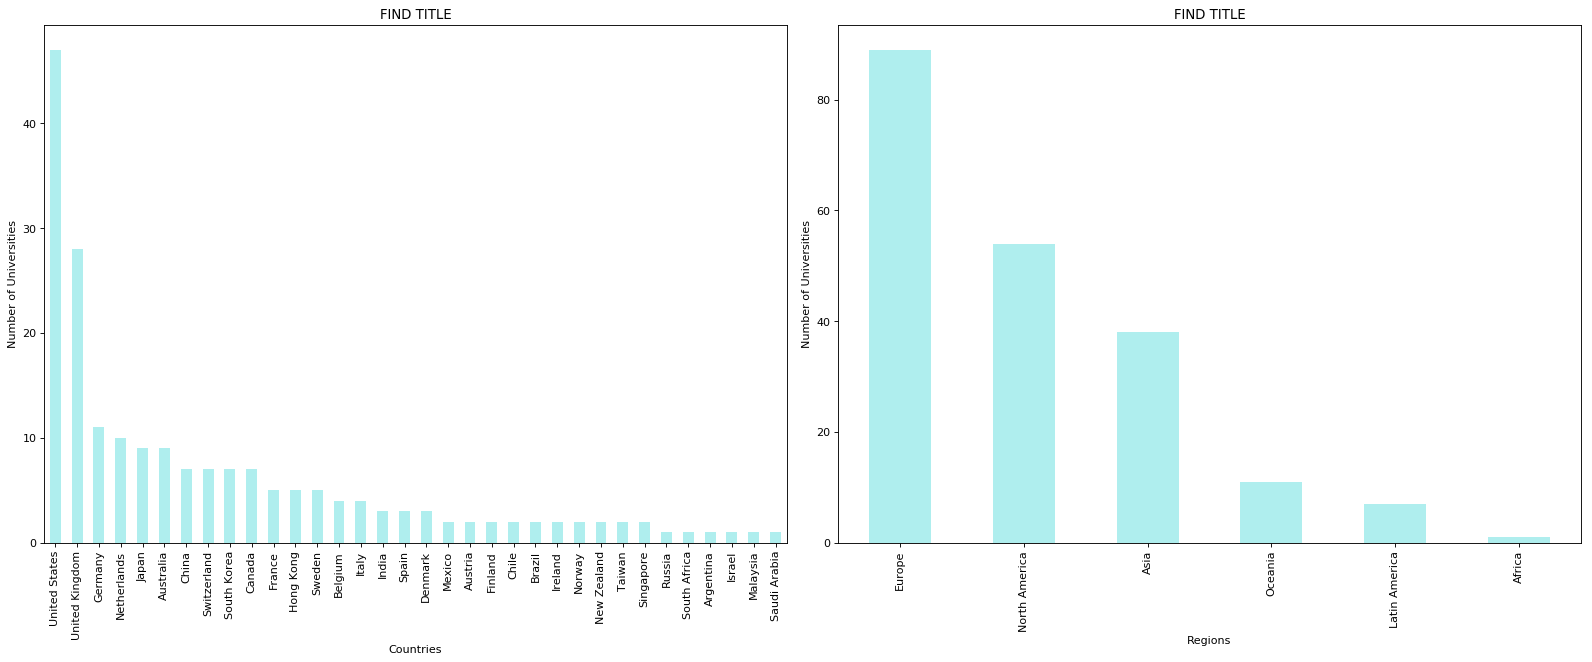

In [35]:
fig=plt.figure(figsize=(20, 15), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2,2,1)
embarkedPlot = qs_df['country'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Countries")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('FIND TITLE')

plt.subplot(2, 2, 2)
embarkedPlot = qs_df['region'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Regions")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('FIND TITLE')

'''plt.subplot(2, 2, 3)
embarkedPlot = qs_df['country'].value_counts().plot(kind='bar', color='paleturquoise')
plt.xlabel('University')
plt.ylabel('Ratio')
plt.title('FIND TITLE')

plt.subplot(2, 2, 4)
embarkedPlot = plt.bar(qs_df['University'].values(), qs_df['QS Ratio Int. Students'].values(), color='paleturquoise')
plt.xlabel('University')
plt.ylabel('Ratio')
plt.title('FIND TITLE')'''

fig.tight_layout()

plt.show()

## Data from Times Higher Education ranking

In [36]:
URL_THE = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(URL_THE)
page_body = r.json()
the_df = pd.DataFrame(page_body['data'])

### Clean the data

In [37]:
the_df = the_df[:200]

## Quelles données nous sont inutiles? 

Je propose de garder: 
- name
- location
- rank
- stats number students
- stats % intl students (to rename and maybe change the percentage by a number)
- stat student staff ratio


#### We calculate the number of International students and then the ratio

In [38]:
# Firts we need to remove the '%' symbol from the column "THE % International Students"
# Then we convert the string to int and we do the calculation

In [39]:
the_df['stats_number_students'] = pd.to_numeric(the_df['stats_number_students'].str.replace(',',''))
the_df['stats_pc_intl_students'] = pd.to_numeric(the_df['stats_pc_intl_students'].str.replace('%',''))
for index, row in the_df.iterrows():
    the_df.loc[index, 'stats_pc_intl_students'] = round(row['stats_number_students']*row['stats_pc_intl_students']*0.01)
    the_df.loc[index, 'THE Ratio Int. Students'] = ratio(row['stats_number_students'], row['stats_pc_intl_students'])


In [40]:
the_df = the_df.loc[ :, ['name', 'rank', 'location','THE Ratio Int. Students', 'stats_student_staff_ratio']]


#### We rename the Data in order to combine the two DF later

In [41]:
the_df = the_df.rename(index=str, columns={ "name" : "University",
                                  "rank": "THE rank", "location": "country",
                                  "stats_student_staff_ratio" : "THE Ratio Students/Staff"
                                 });

In [42]:
the_df;

# On met les deux ensemble

#### Avant de faire ça il faut cleaner les nom. 
Certains noms sont dans la langue naturelle pas en anglais. Il faut traduire
On prend les deux colonnes d'Université, on check si les noms du classement de THE sont dans QS, si oui on renomme QS avec le nom de THE.
Bon complexité de merde, mais ça ira pour l'instant, le Dataset étant pas trop gros

In [43]:
for index_qs, row_qs in qs_df.iterrows():
     for index_the, row_the in the_df.iterrows():
        if row_the['University'] in row_qs['University'] :
            qs_df.loc[index_qs, 'University'] = row_the['University']


In [44]:
def remove_acronyme(column, df):
    for index, row in df.iterrows():
        a = row[column].find('(')
        if a != -1:
            df.loc[index, column] = row[column][:a-1]
remove_acronyme('University', qs_df)     

In [45]:
qs_df['University'];

In [46]:
## Remove accents é (ils posent pb) 
for index, row in qs_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in 'fr':
        qs_df.loc[index, 'University'] = ''.join((c for c in unicodedata.normalize('NFD', row['University']) if unicodedata.category(c) != 'Mn'))

In [47]:
qs_df['University'];

In [48]:
for index, row in the_df.iterrows():
    #the_df.loc[index, 'University'] = row['University'].replace('of','')
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in 'fr':
        the_df.loc[index, 'University'] = ''.join((c for c in unicodedata.normalize('NFD', row['University']) if unicodedata.category(c) != 'Mn'))

In [49]:
qs_df;

#### Translation

In [50]:
for index, row in qs_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in ['de', 'es', 'ms', 'ca', 'la', 'fr']:
        #print(row['University'])
        #print(en_blob.detect_language())
        a = en_blob.translate(to='en')
        qs_df.loc[index, 'University'] = str(a)
        
for index, row in the_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in ['de', 'es', 'ms', 'la', 'fr']:
        print(row['University'])
        print(en_blob.detect_language())
        a = en_blob.translate(to='en')
        the_df.loc[index, 'University'] = str(a)

Ecole Polytechnique Federale de Lausanne
fr
Paris Sciences et Lettres – PSL Research University Paris
fr
Ecole Polytechnique
fr
Charité - Universitätsmedizin Berlin
de
Universite Catholique de Louvain
fr
TU Dresden
de
Universite Libre de Bruxelles
fr
Ecole Normale Superieure de Lyon
fr


### Enlever des mots

In [51]:
#for ( index_qs, row_qs ), ( index_the, row_the ) in zip( qs_df.iterrows(), the_df.iterrows() ) :
 

### Result DataFrame

In [59]:
result = pd.merge(qs_df, the_df, how='outer', on='University')

In [60]:
result

,University,QS rank,country_x,region,QS Ratio Int. Students,QS Ratio Students/Staff,THE rank,country_y,THE Ratio Int. Students,THE Ratio Students/Staff
0,Massachusetts Institute of Technology,1,United States,North America,21.0,21.0,5,United States,1.0,8.7
1,Stanford University,2,United States,North America,1.0,1.0,=3,United States,1.0,7.5
2,Harvard University,3,United States,North America,1.0,1.0,6,United States,2.0,8.9
3,California Institute of Technology,4,United States,North America,1.0,1.0,=3,United States,1.0,6.5
4,University of Cambridge,5,United Kingdom,Europe,1.0,10.0,2,United Kingdom,7.0,10.9
5,University of Oxford,6,United Kingdom,Europe,1.0,10.0,1,United Kingdom,1.0,11.2
6,University College London,7,United Kingdom,Europe,14.0,15.0,16,United Kingdom,1.0,10.5
7,Imperial College London,8,United Kingdom,Europe,2.0,10.0,8,United Kingdom,1.0,11.4
8,University of Chicago,9,United States,North America,1.0,1.0,9,United States,25.0,6.2
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,3.0,1.0,NaN,NaN,NaN,NaN


In [61]:
result = result.drop(['country_x'], axis=1)
result = result.rename(index=str, columns={ "country_y" : "Country"});

In [67]:
result = pd.concat([result.filter(like='University'),
                  result.filter(like=['Country', 'region']), result.filer(like=['rank']), 
                  result.filter(like='Ratio Int. Students'), result.filter(like='Ratio Students/Staff')],  
                  axis=1,  
                  keys=('University', 'Location', 'Rank','Ratio Int. Students', 'Ratio Students/Staff'))

TypeError: 'in <string>' requires string as left operand, not list

,University
,University
,University
0,Massachusetts Institute of Technology
1,Stanford University
2,Harvard University
3,California Institute of Technology
4,University of Cambridge
5,University of Oxford
6,University College London
7,Imperial College London


In [63]:
result = result.rename(index=str, columns={ "QS rank" : "QS", "THE rank" : "THE", 'QS Ratio Int. Students': 'QS',
                                          'THE Ratio Int. Students': 'THE', 'QS Ratio Students/Staff' : 'QS',
                                          'THE Ratio Students/Staff' : 'THE'});

In [57]:
result.to_csv('result.csv')

In [64]:
result

University Location        Rank  \
                                            University       QS   THE    QS   
0                Massachusetts Institute of Technology     21.0   1.0  21.0   
1                                  Stanford University      1.0   1.0   1.0   
2                                   Harvard University      1.0   2.0   1.0   
3                   California Institute of Technology      1.0   1.0   1.0   
4                              University of Cambridge      1.0   7.0  10.0   
5                                 University of Oxford      1.0   1.0  10.0   
6                            University College London     14.0   1.0  15.0   
7                              Imperial College London      2.0   1.0  10.0   
8                                University of Chicago      1.0  25.0   1.0   
9    ETH Zurich - Swiss Federal Institute of Techno...      3.0   NaN   1.0   
10         Nanyang Technological University, Singapore      1.0   1.0   2.0   
11         Federal Institute of Technology in Lausanne      1.0   1.0   1.0   
12                                Princeton University      1.0   1.0   1.0   
13                                  Cornell University      1.0   2.0   2.0   
14                    National University of Singapore      1.0   2.0   2.0   
15                                     Yale University      3.0   1.0  26.0   
16                            Johns Hopkins University      1.0   6.0  46.0   
17                                 Columbia University      5.0   1.0   1.0   
18                          University of Pennsylvania      1.0   1.0   1.0   
19                      Australian National University      1.0   1.0   2.0   
20                              University of Michigan     13.0   2.0   1.0   
21                                     Duke University      8.0   2.0   2.0   
22                             University of Edinburgh      1.0   1.0   5.0   
23                               King's College London      1.0   NaN  10.0   
24                                 Tsinghua University      4.0   1.0   2.0   
25                             University of Hong Kong      2.0   2.0   6.0   
26                  University of California, Berkeley     17.0   1.0   1.0   
27                                 University of Tokyo      7.0  10.0   1.0   
28                             Northwestern University      1.0   6.0   1.0   
29      Hong Kong University of Science and Technology      1.0   1.0  25.0   
..                                                 ...      ...   ...   ...   
224                              University of Cologne      NaN   1.0   NaN   
225                               University of Sussex      NaN   2.0   NaN   
226                           University of Notre Dame      NaN   1.0   NaN   
227                         Scuola Superiore Sant’Anna      NaN   2.0   NaN   
228                    Technical University of Dresden      NaN   1.0   NaN   
229                                     Ulm University      NaN   1.0   NaN   
230                    Case Western Reserve University      NaN   1.0   NaN   
231                            University of Leicester      NaN   1.0   NaN   
232                              University of Arizona      NaN   3.0   NaN   
233               University of California, Santa Cruz      NaN   2.0   NaN   
234                   University of Erlangen-Nuremberg      NaN   6.0   NaN   
235                       Vrije Universiteit Amsterdam      NaN   1.0   NaN   
236                             University of Würzburg      NaN   1.0   NaN   
237                University of Alabama at Birmingham      NaN   1.0   NaN   
238                                   Tufts University      NaN   1.0   NaN   
239        Rutgers, the State University of New Jersey      NaN   1.0   NaN   
240                              University of Münster      NaN   7.0   NaN   
241                        Free University of Brussels      NaN   1.0   NaN   
242            